In [1]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from rasterio import mask as msk 
from shapely.geometry import mapping
import pandas as pd
from shapely.geometry import Point

In [8]:
# Data source - https://github.com/nvkelso/natural-earth-vector/blob/master/10m_cultural/ne_10m_admin_0_countries.shp
df = gpd.read_file('../../Scipy2025_workshop/resources/data/ne_10m_admin_0_countries.shp')

/var/folders/7m/pqxqc6zd6lj5xs7y0vdddxf40000gn/T/ipykernel_5453/1666950778.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sub_cont2.geometry = sub_cont2.geometry.buffer(42, 1)


<Axes: >

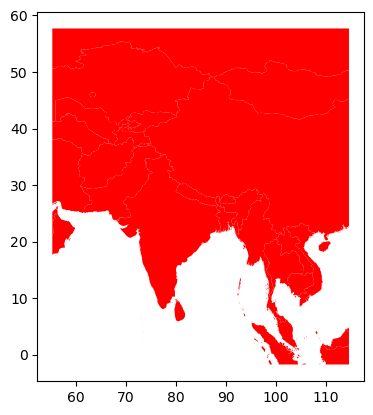

In [9]:
sub_cont = df.loc[df['ADMIN'].isin(['China', 'Laos', 'Thailand', 'Vietnam', 'Cambodia', 'India', 'Pakistan', 'Bangladesh', 'Nepal', 'Bhutan', 'Myanmar', 'Sri Lanka', 'Afghanistan'])]

sub_cont2 = gpd.GeoDataFrame(pd.DataFrame({'name': ['test']}), crs='EPSG:4326', geometry=[Point(85, 28)])
sub_cont2.geometry = sub_cont2.geometry.buffer(42, 1)
sub_cont2.geometry = sub_cont2.geometry.rotate(45)

union = sub_cont2.overlay(df, how='union')
difference = sub_cont2.overlay(df, how='difference')
symmetric_difference = sub_cont2.overlay(df, how='symmetric_difference')
intersection = sub_cont2.overlay(df, how='intersection')


fig, ax = plt.subplots()

intersection.plot(ax=ax, color='red')
#sub_cont.plot(ax=ax)

In [15]:
# Data Source - https://www.ngdc.noaa.gov/mgg/global/relief/ETOPO1/data/bedrock/grid_registered/georeferenced_tiff/
topography_file = rasterio.open('../../Scipy2025_workshop/resources/data/downsampled_topography.tif')


In [16]:
clipped_array, clipped_transform = rasterio.mask.mask(topography_file, [mapping(geom) for geom in (intersection.geometry.tolist())], 
                                                      crop=True, nodata=0)

In [17]:
import numpy as np

print(np.amin(clipped_array))
print(np.amax(clipped_array))

-199
6393


In [18]:
clipped_array, clipped_transform = rasterio.mask.mask(topography_file, [mapping(geom) for geom in (intersection.geometry.tolist())], 
                                                      crop=True, nodata=-199)

In [19]:
from osgeo import gdal, ogr, osr
from rasterio.transform import from_origin

#(originX, pixelWidth, rotX, originY, rotY, pixelHeight)
gdal_transform = (clipped_transform.c, clipped_transform.a, clipped_transform.b,
                  clipped_transform.f, clipped_transform.d, clipped_transform.e)

#in memory raster
mem_drv_raster = gdal.GetDriverByName('MEM')
mem_raster = mem_drv_raster.Create('', clipped_array[0].shape[1], clipped_array[0].shape[0], 1, gdal.GDT_Int32)
mem_raster.SetGeoTransform(gdal_transform)
mem_raster.GetRasterBand(1).WriteArray(clipped_array[0])

# in memory ogr layer for contours
drv = ogr.GetDriverByName('Memory')
mem_ds = drv.CreateDataSource('')
contour_lyr = mem_ds.CreateLayer(
    'contours',
    geom_type=ogr.wkbLineString25D
)

#define attributes
for name, ftype in [('ID', ogr.OFTInteger), ('ELEV', ogr.OFTReal)]:
    fld = ogr.FieldDefn(name, ftype)
    contour_lyr.CreateField(fld)

#create contours
gdal.ContourGenerate(mem_raster.GetRasterBand(1), 50, -11, [], 0, 0, contour_lyr, 0, 1)


/opt/anaconda3/envs/pyvista/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
Warning 1: DeprecationWarning: 'Memory' driver is deprecated since GDAL 3.11. Use 'MEM' onwards. Further messages of this type will be suppressed.


0

In [20]:
from shapely.geometry import LineString
import pandas as pd
lines = [LineString(np.array(contour.GetGeometryRef().GetPoints())) for contour in contour_lyr]
elev = [contour.GetField('elev') for contour in contour_lyr]
gdf = gpd.GeoDataFrame(pd.DataFrame({'elev': elev}), crs="EPSG:4326", geometry=lines)
print(gdf)

         elev                                           geometry
0       189.0  LINESTRING Z (89.1213 57.59167 189, 89.075 57....
1       189.0  LINESTRING Z (89.45379 57.59167 189, 89.40833 ...
2       189.0  LINESTRING Z (90.075 57.59167 189, 90.075 57.5...
3       239.0  LINESTRING Z (61.11944 57.59167 239, 61.075 57...
4       289.0  LINESTRING Z (60.09312 57.59167 289, 60.075 57...
...       ...                                                ...
33392   939.0  LINESTRING Z (100.99361 -1.575 939, 100.90833 ...
33393   989.0  LINESTRING Z (100.97414 -1.575 989, 100.90833 ...
33394  1039.0  LINESTRING Z (100.95467 -1.575 1039, 100.90833...
33395  1089.0  LINESTRING Z (100.9352 -1.575 1089, 100.90833 ...
33396  1139.0  LINESTRING Z (100.91573 -1.575 1139, 100.90833...

[33397 rows x 2 columns]


<Axes: >

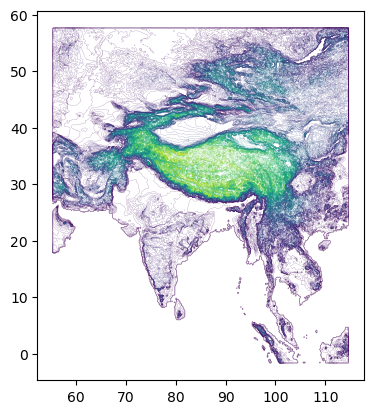

In [21]:
gdf.plot(lw=0.1, column='elev')

In [22]:
print(gdf)

         elev                                           geometry
0       189.0  LINESTRING Z (89.1213 57.59167 189, 89.075 57....
1       189.0  LINESTRING Z (89.45379 57.59167 189, 89.40833 ...
2       189.0  LINESTRING Z (90.075 57.59167 189, 90.075 57.5...
3       239.0  LINESTRING Z (61.11944 57.59167 239, 61.075 57...
4       289.0  LINESTRING Z (60.09312 57.59167 289, 60.075 57...
...       ...                                                ...
33392   939.0  LINESTRING Z (100.99361 -1.575 939, 100.90833 ...
33393   989.0  LINESTRING Z (100.97414 -1.575 989, 100.90833 ...
33394  1039.0  LINESTRING Z (100.95467 -1.575 1039, 100.90833...
33395  1089.0  LINESTRING Z (100.9352 -1.575 1089, 100.90833 ...
33396  1139.0  LINESTRING Z (100.91573 -1.575 1139, 100.90833...

[33397 rows x 2 columns]


In [23]:
gdf   = gdf.to_crs("EPSG:3857")        # metres in x/y


In [24]:
from shapely.geometry import Point
import itertools
import pyvista as pv

def gdf_to_ug(gdf, elevation='z'):
    """ Transforms a geopandas geodataframe into a pyvista unstructured grid

    Parameters
    ----------
    gdf : geopandas.GeoDataFrame
        A geodataframe with unique index values

    elevation : str
        Column name for the elevation field

    Returns
    -------
    pv.core.pointset.UnstructuredGrid
        A pyvista unstructured grid containing Point, LineString and Polygon with associated data
    """

    points = []
    point_cells = []
    tubes = {}
    cell_data = []
    k = 0
    point_idx = 0
    # iterate over the rows
    for idx, row in gdf.iterrows():
        if isinstance(row.geometry, Point):
            x, y, z = row.geometry.x, row.geometry.y, row[elevation]
            points.append([x, y, z])
            cell_data.append(row[elevation])
            point_cells.append([1, point_idx])
            point_idx += 1

        elif isinstance(row.geometry, LineString) or isinstance(row.geometry, Polygon):
            line_vertices = []

            # iterate over the vertices
            if isinstance(row.geometry, LineString):
                number_of_vertices = len(list(row.geometry.coords))
                vertices = zip(row.geometry.xy[0], row.geometry.xy[1], itertools.repeat(row[elevation]))
            elif isinstance(row.geometry, Polygon):
                number_of_vertices = len(list(row.geometry.exterior.coords))
                vertices = zip(row.geometry.exterior.xy[0], row.geometry.exterior.xy[1],
                               itertools.repeat(row[elevation]))
            else:
                print(f'Invalid geometry type : {type(row.geometry)}')
                return
            for vertex in vertices:
                line_vertices.append([vertex[0], vertex[1], vertex[2]])
            line_vertices = np.array(line_vertices)

            # get the number of vertices and create a cell sequence

            line_cells = np.array([number_of_vertices] + [i for i in range(number_of_vertices)])
            unstructured_grid = pv.UnstructuredGrid(line_cells, np.array([4]), line_vertices)
            # we can add some values to the point
            unstructured_grid.cell_data['Elevation'] = row[elevation]
            tubes[str(k)] = unstructured_grid
            k += 1

    if len(points) > 0:
        # Create an unstructured grid object for all the points and associate data
        unstructured_grid = pv.UnstructuredGrid(np.array(point_cells), np.array([1] * len(points)), np.array(points))
        unstructured_grid.cell_data['Elevation'] = cell_data

        # Merge tubes created from lines and
        tubes[str(k)] = unstructured_grid

    # print(tubes)
    blocks = pv.MultiBlock(tubes)
    unstructured_grid = blocks.combine()
    return unstructured_grid

poly = gdf_to_ug(gdf, elevation='elev')

In [25]:
# 3.  save and/or plot
poly.save("lines.vtk")       # writes legacy .vtk or .vtp if you prefer


In [26]:
dataset = pv.read("lines.vtk")
dataset

UnstructuredGrid (0x332e06ec0)
  N Cells:    33397
  N Points:   605819
  X Bounds:   6.150e+06, 1.277e+07
  Y Bounds:   -1.934e+05, 7.916e+06
  Z Bounds:   -1.610e+02, 6.389e+03
  N Arrays:   1

In [28]:
# ➊ convert cell_data → point_data
dataset_pt = dataset.cell_data_to_point_data(
                 pass_cell_data=True   # keep original cell arrays too (optional)
             )

# ➋ warp with the new point-data array
dataset_3d = dataset_pt.warp_by_scalar(
                 scalars="Elevation",  # now lives in point_data
                 factor=100.0            # metres → metres; tweak to exaggerate
             )

dataset_3d.plot(
    scalars="Elevation",
    line_width=1,
    cmap="inferno"
)


Widget(value='<iframe src="http://localhost:51864/index.html?ui=P_0x3319c34d0_1&reconnect=auto" class="pyvista…